# Examen Práctico

#### 01-3900 | Ciencia de datos | 2024

Alumno:

## Enunciado

Se tienen un dataset con datos de pacientes internados en un hospital (TP_Virus_Alumnos.csv). La clase de interes (1) refiere a la presencia de un virus. El virus tiene normalmente una gravedad leve/baja y el tratamiento suele ser invasivo. Datos como nombre y apellido han sido eliminados y los valores tanto en sangre (BLD), hormonales u otros análisis sobre reactivos han sido alterados en sus valores para preservar la privacidad. Se aclara que no se ha modificado su capacidad predictiva (Si es que la tienen).


Para su conocimiento: </BR>
Datos generales de Edad, Peso, Altura y condición laboral (Activo, Pasivo etc).
Datos medidos en hospital:</BR>
BLD: Sangre</BR>
LVL: Hormonales</BR>
REC: Otros análisis</BR>

Se pide obtener con los datos disponibles el mejor modelo posible que prediga la presencia o ausencia del virus.
Dado que el tratamiento es invasivo y la grevedad es moderada se requiere "atrapar" tantos "1" como sea posible y minimizar los falsos positivos para evitar que reciban un tratamiento de estas caracteristicas personas que no presentan el virus. Intente obtener el mejor modelo que maximice la métrica que considere correspondiente.



## Como desarrollar el exámen

A partir del dataset realice todas las acciones para poder llegar al mejor modelo, explique brevemente en los fundamentos de sus transformaciones o acciones en general.

La nota derivará de: </BR>
1.La calidad de la clasificación realizada</BR>
2.La fundamentación de los pasos realizados</BR>
3.Lo sencillo de llevar a producción el desarrollo</BR>



Los docentes evaluaran su clasificador utilizando un conjunto de datos del dataset "fuera de la caja" (out of the box, al que usted no tiene acceso). Para minimizar la posible diferencia entre su medición y la medición del docente recuerde y aplique conceptos de test, validación cruzada y evite los errores comunes de sesgo de selección y fuga de datos (PPT/Pdf Árboles de clasificación) o  Sklearn "10. Common pitfalls and recommended practices" disponible en "https://scikit-learn.org/stable/common_pitfalls.html"   

Al final del notebook encontrará un bloque de código que lee la muestra adicional (a la que usted no tiene acceso) si PRODUCCION==True, en caso contrario solo lee una submuestra del conjunto original para validar que el código funciona. Desarrolle el notebook como considere, para finalmente asignar el mejor clasificador que usted haya obtenido remplazando en f_clf = None, None por su clasificador. Implemente todas las transformaciones entre esa línea y la predición final (Evitando al fuga de datos). Ver TP_AutomatizarTransformaciones.ipynb

En materiales del MIEL se adjunta un notebook que propone algunas ideas para automatizar el proceso.

## Evaluacion final - Docente + Alumno

In [7]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns

PRODUCCION = False
best_clf = None #Asignar aqui el mejor clasificador posible (previamente entrenado)

#Leemos el dataset de evaluación, simulando producción
if PRODUCCION==False:
    df = pd.read_csv("TP_Virus_Alumnos.csv")
    _, df = train_test_split(df, test_size=0.3, random_state=42)
else:
    df = pd.read_csv("TP_Virus_Evaluacion.csv")
#Dividimos en target y predictoras

X_prod = df.drop("target", axis=1)
y_prod = df["target"]

#Transformaciones


#Evaluación final
#y_pred = best_clf.predict(X_prod)
#print(classification_report(y_prod, y_pred))
print(df)

      Edad     Genero       Peso   Laboral  hijos     BLD01      REC1  \
1743  77.0        NaN  84.074534  Inactivo      3  0.375782  2.961876   
2196  16.0        NaN  55.164510  Inactivo      0  0.619332  4.294339   
1728  33.0        NaN  96.989635    Activo      3  0.681815  0.205533   
3337  16.0        NaN  66.278474  Inactivo      0  1.071266  5.365205   
298   20.0        NaN  59.600519  Inactivo      0  0.232450  4.283054   
...    ...        ...        ...       ...    ...       ...       ...   
1992  71.0  Masculino  86.545914    Activo      3  0.665836  7.084822   
3924  39.0        NaN  89.972114    Activo      0  1.792074  4.371774   
1105  37.0        NaN  90.573156  Inactivo      2  0.962825  4.727052   
1615   9.0   Femenino  37.043624  Inactivo      0 -0.024500  2.408985   
1556  70.0  Masculino  75.349012  Inactivo      3  0.717138  1.604982   

           REC2       REC3       REC4       REC5     BLD02     BLD03  \
1743  64.048710  72.270697  15.043639  90.859844  0

calcular precision



In [4]:
# verificamos los tipos de datos
df.dtypes

Edad       float64
Genero      object
Peso       float64
Laboral     object
hijos        int64
BLD01      float64
REC1       float64
REC2       float64
REC3       float64
REC4       float64
REC5       float64
BLD02      float64
BLD03      float64
LVL        float64
target       int64
dtype: object

In [5]:
# Verificamos si hay valores nulos para imputar
df.isnull().sum()

Edad       252
Genero     506
Peso         0
Laboral      0
hijos        0
BLD01        0
REC1         0
REC2         0
REC3         0
REC4         0
REC5         0
BLD02        0
BLD03        0
LVL        169
target       0
dtype: int64

Edad
16.0    26
65.0    25
68.0    24
4.0     23
70.0    21
        ..
34.0     5
45.0     4
22.0     4
25.0     4
55.0     4
Name: count, Length: 80, dtype: int64


<Axes: xlabel='Edad', ylabel='count'>

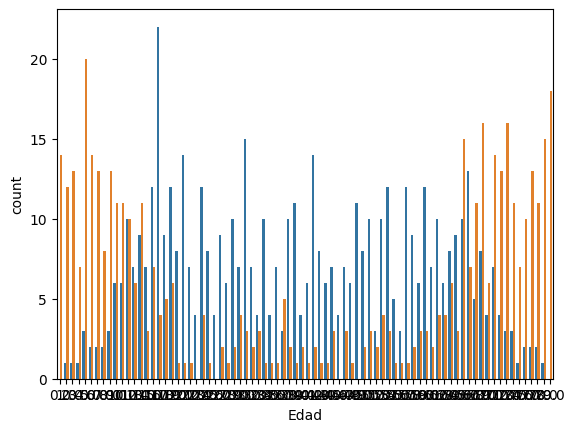

In [9]:
# Analisis de la distribución de la variable target "Hazardous"
print( df.Edad.value_counts() )
sns.countplot(x='Edad', data=df, hue='target', legend=False)

In [ ]:
# Analisis de la distribución de la variable target "Hazardous"
print( df_nasa.Hazardous.value_counts() )
sns.countplot(x='Hazardous', data=df_nasa, hue='Hazardous', legend=False)